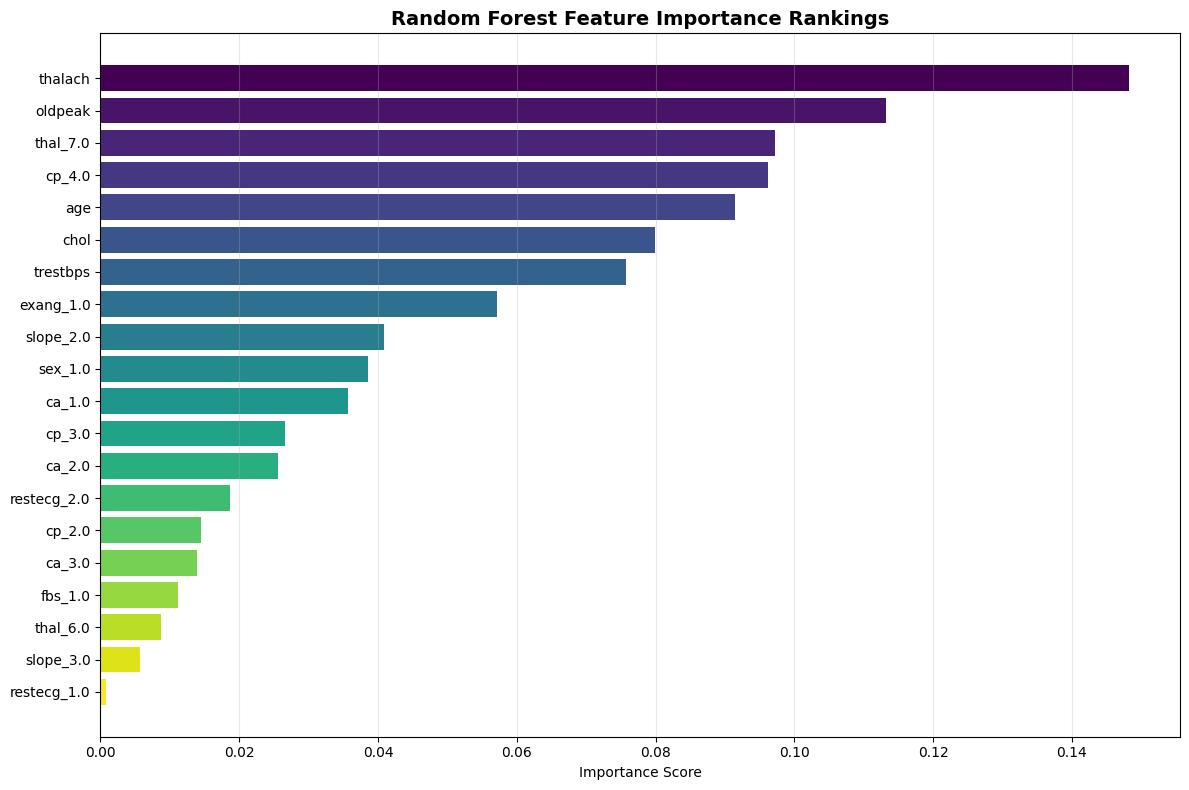

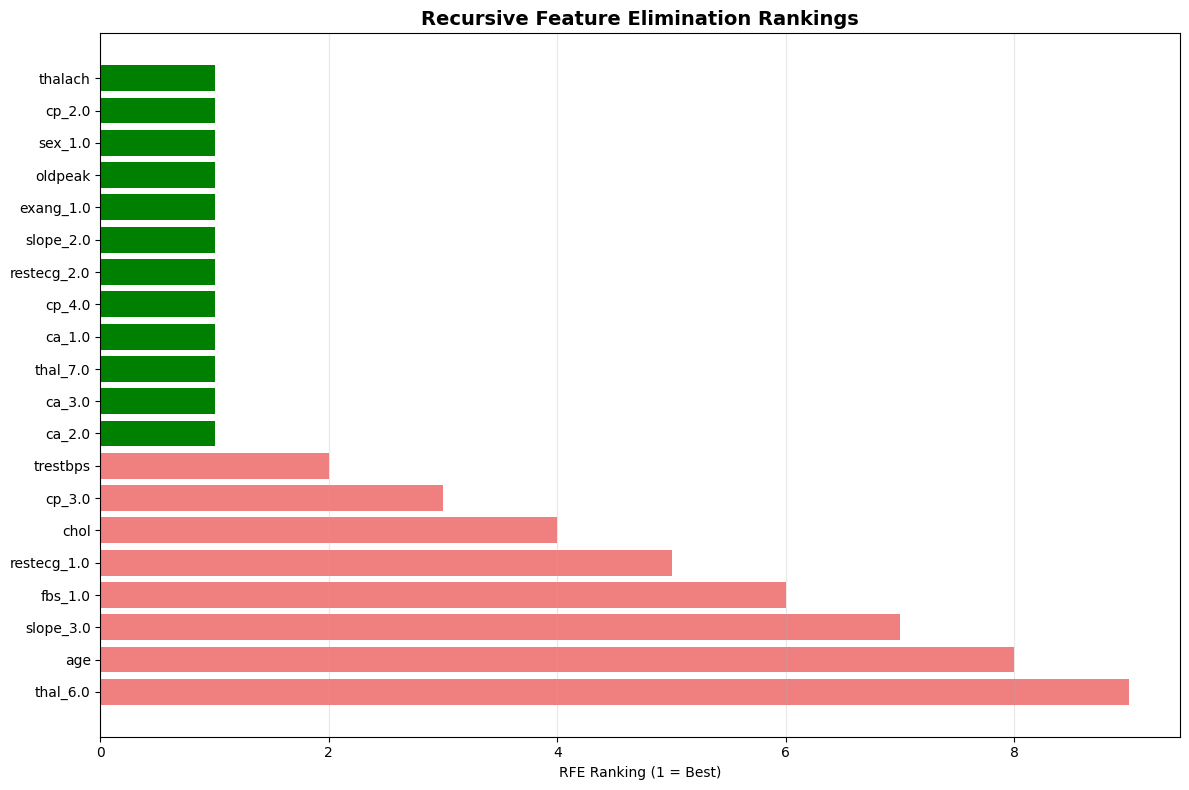

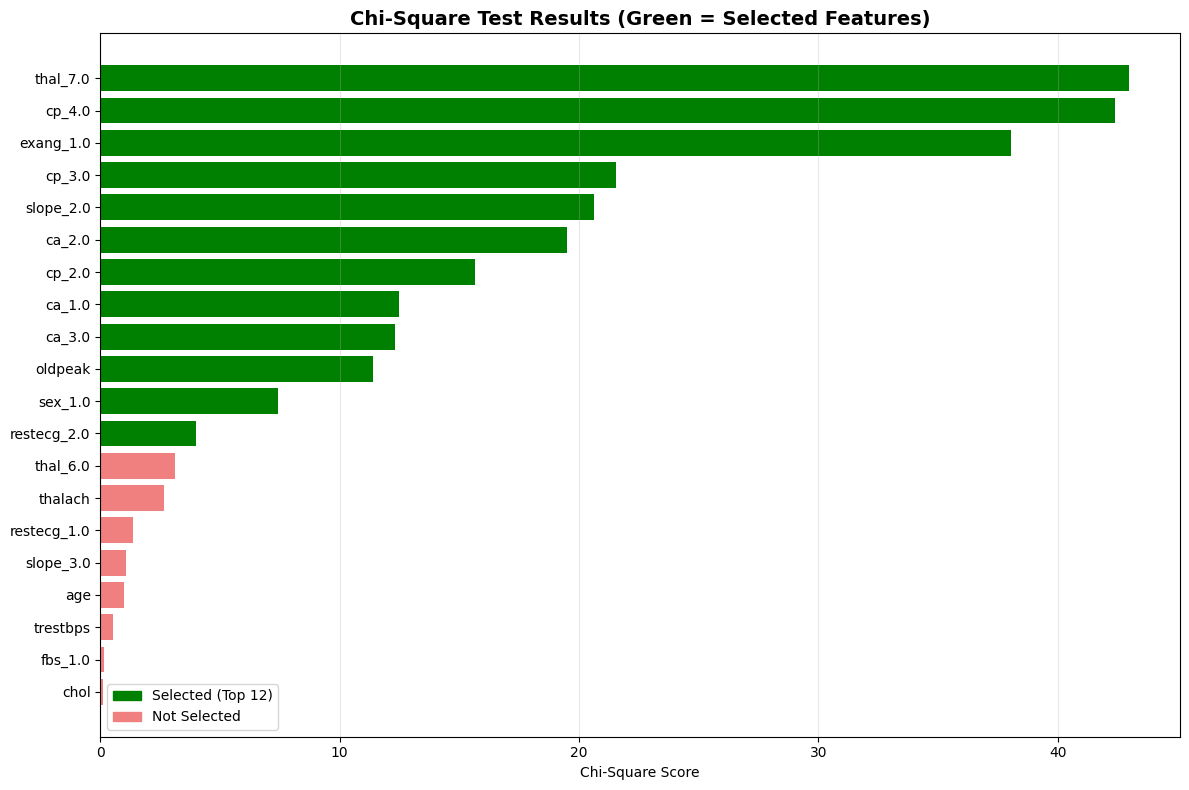

                   RF  RFE       Chi2     Score
thal_7.0     0.097233    1  42.958360  0.884836
cp_4.0       0.096145    1  42.410097  0.878113
exang_1.0    0.057223    1  38.052613  0.756208
thalach      0.148166    1   2.670638  0.686579
oldpeak      0.113265    1  11.382669  0.675440
slope_2.0    0.040865    1  20.624160  0.583636
ca_2.0       0.025617    1  19.509795  0.540489
ca_1.0       0.035661    1  12.461167  0.508364
cp_2.0       0.014479    1  15.646367  0.485248
cp_3.0       0.026595    3  21.551109  0.484507
sex_1.0      0.038605    1   7.432845  0.475901
trestbps     0.075685    2   0.532647  0.469025
ca_3.0       0.013951    1  12.330323  0.458257
restecg_2.0  0.018697    1   3.987845  0.404088
chol         0.079924    4   0.111079  0.401256
age          0.091400    8   1.005896  0.286018
restecg_1.0  0.000743    5   1.366567  0.194952
fbs_1.0      0.011249    6   0.164669  0.172320
slope_3.0    0.005786    7   1.073891  0.130003
thal_6.0     0.008712    9   3.133971  0

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, chi2,SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
import matplotlib.patches as mpatches


file_path = "../data/processed_heart_disease.csv"
heart_df = pd.read_csv(file_path)

x=heart_df.drop("target",axis=1)
y=heart_df["target"]


rf=RandomForestClassifier(random_state=42)
rf.fit(x,y)

importances = pd.Series(rf.feature_importances_, index=x.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(importances)))
bars = plt.barh(range(len(importances)), importances.values, color=colors)
plt.yticks(range(len(importances)), importances.index)
plt.xlabel('Importance Score')
plt.title('Random Forest Feature Importance Rankings', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()  
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()



lr=LogisticRegression(random_state=42, max_iter=1000)
rfe=RFE(estimator=lr, n_features_to_select=12)
rfe.fit(x, y)

rfe_selected = x.columns[rfe.support_].tolist()
rfe_ranking = pd.Series(rfe.ranking_, index=x.columns).sort_values()

plt.figure(figsize=(12, 8))
colors = ['green' if rank == 1 else 'lightcoral' for rank in rfe_ranking.values]
plt.barh(range(len(rfe_ranking)), rfe_ranking.values, color=colors)
plt.yticks(range(len(rfe_ranking)), rfe_ranking.index)
plt.xlabel('RFE Ranking (1 = Best)')
plt.title('Recursive Feature Elimination Rankings', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()



X_scaled=MinMaxScaler().fit_transform(x)
chi2_selector=SelectKBest(score_func=chi2, k=12)
chi2_selector.fit(X_scaled, y)
selected_chi2 = x.columns[chi2_selector.get_support()]
chi2_scores = pd.Series(chi2_selector.scores_, index=x.columns).sort_values(ascending=False)
plt.figure(figsize=(12, 8))
colors = ['green' if feature in selected_chi2 else 'lightcoral' for feature in chi2_scores.index]
plt.barh(range(len(chi2_scores)), chi2_scores.values, color=colors)
plt.yticks(range(len(chi2_scores)), chi2_scores.index)
plt.xlabel('Chi-Square Score')
plt.title('Chi-Square Test Results (Green = Selected Features)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
selected_patch = mpatches.Patch(color='green', label='Selected (Top 12)')
not_selected_patch = mpatches.Patch(color='lightcoral', label='Not Selected')
plt.legend(handles=[selected_patch, not_selected_patch])
plt.tight_layout()
plt.show()

feature_comparison = pd.DataFrame({
    'RF': importances,
    'RFE': rfe_ranking,
    'Chi2': chi2_scores
})

feature_comparison['RF_norm'] = (feature_comparison['RF'] - feature_comparison['RF'].min()) / (feature_comparison['RF'].max() - feature_comparison['RF'].min())
feature_comparison['RFE_norm'] = (feature_comparison['RFE'].max() + 1 - feature_comparison['RFE']) / feature_comparison['RFE'].max()
feature_comparison['Chi2_norm'] = (feature_comparison['Chi2'] - feature_comparison['Chi2'].min()) / (feature_comparison['Chi2'].max() - feature_comparison['Chi2'].min())


feature_comparison['Score'] = feature_comparison[['RF_norm','RFE_norm','Chi2_norm']].mean(axis=1)
feature_comparison = feature_comparison.sort_values('Score', ascending=False)



N = 12   
final_features = feature_comparison.head(N).index.tolist()

print(f"\nTop {N} Selected Features:")
print(final_features)


final_dataset = heart_df[final_features + ['target']]
final_dataset.to_csv("../data/heart_disease_selected_features.csv", index=False)


selected_rf   = importances.head(12).index.tolist()
selected_rfe  = rfe_ranking[rfe_ranking == 1].index.tolist()   
selected_chi2 = chi2_scores.head(12).index.tolist()


union_features = set(selected_rf).union(set(selected_rfe)).union(set(selected_chi2))
union_dataset=heart_df[list(union_features)+['target']]
union_dataset.to_csv("../data/heart_disease_union_features.csv", index=False)
